<a href="https://colab.research.google.com/github/DJCordhose/ux-by-tfjs/blob/master/notebooks/rnn-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training on Mouse-Movements on the Server

In [1]:
# !pip install -q tf-nightly-gpu-2.0-preview

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [3]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print("This works: {}".format(hello))

This works: b'Hello TF!'


In [4]:
# this should return True even on Colab
tf.test.is_gpu_available()

True

In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
tf.executing_eagerly()

True

## load data

In [7]:
import pandas as pd
print(pd.__version__)

0.23.4


In [8]:
df = pd.read_json('../data/sample2.json', typ='series')

In [9]:
len(df)

205

In [10]:
df.head()

0    {'x': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0...
1    {'x': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0...
2    {'x': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0...
3    {'x': [[644, 266, 2, 6, 7], [644, 268, 0, 6, 7...
4    {'x': [[956, 283, 2, -6, 7], [957, 278, 2, -8,...
dtype: object

In [11]:
X = [item['x'] for item in df]

In [12]:
X[0]

[[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0,

In [13]:
y = [item['y'] - 1 for item in df]

In [14]:
y[0]

0

In [15]:
from math import floor

def make_chunks(list_to_chunk, chunk_size):
    length = len(list_to_chunk)
    assert length / chunk_size == floor(length / chunk_size), "length of data must be multiple of segment length"
    for chunk_start in range(0, length, chunk_size):
        yield list_to_chunk[chunk_start : chunk_start + chunk_size]

In [16]:
import numpy as np

CHUNK_SIZE = 50
SEGMENTS = 4

X_expanded = []
y_expanded = []

for x_el, y_el in zip(X, y):
    chunks = list(make_chunks(x_el, CHUNK_SIZE))
    labels = [y_el] * SEGMENTS
    for seq, label in zip(chunks, labels):
        X_expanded.append(seq)
        y_expanded.append(label)

X_expanded = np.array(X_expanded)
y_expanded = np.array(y_expanded)

In [17]:
X_expanded.shape

(820, 50, 5)

In [18]:
X_expanded[100]

array([[792, 356,   0,   2,   7],
       [792, 357,   0,   0,   8],
       [791, 357,  -2,   2,   7],
       [791, 358,   0,   0,   8],
       [790, 358,  -2,   2,  14],
       [790, 359,   0,   0,   7],
       [790, 358,   0,   0,  85],
       [790, 357,   0,  -4,   8],
       [790, 356,   0,   0,   7],
       [792, 348,   4, -16,  14],
       [798, 334,  12, -30,   7],
       [807, 313,  18, -40,   7],
       [810, 303,   6, -20,   7],
       [812, 297,   4, -14,   7],
       [812, 291,   0, -10,   8],
       [812, 284,   0, -16,   7],
       [812, 278,   0, -10,   7],
       [811, 274,  -2, -10,   7],
       [808, 270,  -6,  -8,   8],
       [806, 267,  -4,  -4,   6],
       [804, 265,  -4,  -4,   8],
       [803, 263,  -2,  -4,   6],
       [801, 262,  -4,  -2,   8],
       [799, 261,  -4,  -4,   7],
       [796, 260,  -6,   0,   7],
       [794, 259,  -4,  -2,   7],
       [788, 259, -12,   0,   7],
       [781, 259, -14,   0,   7],
       [772, 260, -18,   2,   7],
       [765, 2

In [19]:
X_expanded[100][0]

array([792, 356,   0,   2,   7])

In [20]:
y_expanded[100]

2

In [21]:
np.unique(y_expanded)

array([0, 1, 2])

In [22]:
assert np.array_equal(np.unique(y_expanded), [0, 1, 2])

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.models import Sequential, Model

In [24]:
n_steps = len(X_expanded[0])
n_features = len(X_expanded[0][0])
n_buttons = 3

# define model
model = Sequential()
model.add(GRU(units=50, activation='tanh', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(Dense(units=n_buttons, name='softmax', activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
%%time

EPOCHS = 1000
BATCH_SIZE = 200

history = model.fit(X_expanded, y_expanded, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, verbose=0, validation_split=0.2)

Wall time: 52 s


In [26]:
loss, accuracy = model.evaluate([X_expanded], y_expanded, batch_size=BATCH_SIZE)
accuracy

820/820 [==============================] - 0s 36us/sample - loss: 0.8864 - accuracy: 0.5854


0.58536583

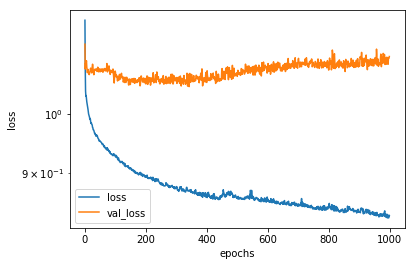

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['loss', 'val_loss'])

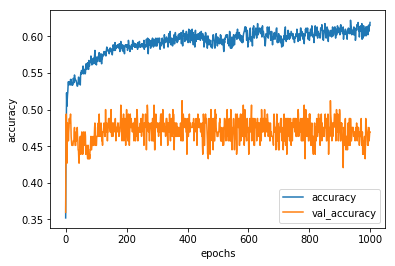

In [28]:
plt.ylabel('accuracy')
plt.xlabel('epochs')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(['accuracy', 'val_accuracy'])

In [29]:
model.predict([[X_expanded[0]]])

array([[0.6581337 , 0.33938646, 0.0024799 ]], dtype=float32)

In [30]:
model.predict([[X_expanded[0]]]).argmax()

0

In [31]:
y_expanded[0]

0

In [32]:
model.save('ux.hd5')